In [28]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word).lower())
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [29]:
import re
def preprocessing(line):
    line = re.sub(r'[^a-zA-z.?!\']', ' ', line)
    line = re.sub(r'[ ]+', ' ', line)
    return line

In [30]:
import pandas as pd
df = pd.read_json('./intent.json')
df.head()

,intent,text,responses,extension,context,entityType,entities
0,Greeting,"[Hi, Hi there, Hola, Hello, Hello there, Hya, ...","[Hi human, please tell me your GeniSys user, H...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingUserRequest', 'clea...",NA,[]
1,GreetingResponse,"[My user is Adam, This is Adam, I am Adam, It ...","[Great! Hi <HUMAN>! How can I help?, Good! Hi ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo'..."
2,CourtesyGreeting,"[How are you?, Hi how are you?, Hello how are ...","[Hello, I am great, how are you? Please tell m...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'CourtesyGreetingUserRequest...",NA,[]
3,CourtesyGreetingResponse,"[Good thanks! My user is Adam, Good thanks! Th...","[Great! Hi <HUMAN>! How can I help?, Good! Hi ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 5, 'rangeTo'..."
4,CurrentHumanQuery,"[What is my name?, What do you call me?, Who d...","[You are <HUMAN>! How can I help?, Your name i...",{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


In [31]:
intent = []
for field in df.values:
    for text in field[1]:
        intent.append({'intent':field[0], 'caption':preprocessing(text)})
df = pd.DataFrame(intent)
df.head()

,intent,caption
0,Greeting,Hi
1,Greeting,Hi there
2,Greeting,Hola
3,Greeting,Hello
4,Greeting,Hello there


In [32]:
print(', '.join(set(df['intent'])))

SelfAware, Shutup, CourtesyGoodBye, Jokes, NotTalking2U, CourtesyGreeting, Swearing, UnderstandQuery, RealNameQuery, GoodBye, Thanks, TimeQuery, Gossip, Clever, CurrentHumanQuery, PodBayDoor, CourtesyGreetingResponse, WhoAmI, GreetingResponse, PodBayDoorResponse, NameQuery, Greeting


In [33]:
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()
df['caption'] = df['caption'].apply(stemSentence)
df['caption'].head()

0            hi 
1       hi ther 
2           hol 
3         hello 
4    hello ther 
Name: caption, dtype: object

In [34]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(filters='', oov_token='<unk>')
tokenizer.fit_on_texts(df['caption'])

In [35]:
vocab_size = len(tokenizer.word_index)+1
maxlen = len(max(df['caption'], key = len))
print(vocab_size, maxlen)

117 36


In [36]:
from keras.preprocessing.sequence import pad_sequences
encoded = tokenizer.texts_to_sequences(df['caption'])
padded = pad_sequences(encoded, maxlen = maxlen, padding = "pre")
padded.shape

(143, 36)

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
le = LabelEncoder()
intents = le.fit_transform(df['intent'])
intents = intents.reshape(-1,1)
intents = ohe.fit_transform(intents).toarray()
intents.shape

(143, 22)

In [38]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(padded, intents, test_size = 0.15)
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

(121, 36) (121, 22)
(22, 36) (22, 22)


In [39]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
model = Sequential()
model.add(Embedding(vocab_size, 512))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
model.add(Dense(22, activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 512)         59904     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               656384    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 22)                5654      
Total params: 721,942
Trainable params: 721,942
Non-trainable params: 0
_________________________________________________________________


In [40]:
from keras.callbacks import EarlyStopping 
from keras.callbacks import ModelCheckpoint
filepath = "weights.best.hdf5"
cp_callback = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es_callback = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_X, train_Y,
                    epochs = 50, 
                    validation_data=(test_X, test_Y), 
                    batch_size=32,
                    callbacks=[es_callback,cp_callback])

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 3.1024 - accuracy: 0.0826
Epoch 00001: val_accuracy improved from -inf to 0.18182, saving model to weights.best.hdf5
4/4 [==============================] - 3s 694ms/step - loss: 3.1024 - accuracy: 0.0826 - val_loss: 3.1119 - val_accuracy: 0.1818
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 3.0455 - accuracy: 0.0909
Epoch 00002: val_accuracy did not improve from 0.18182
4/4 [==============================] - 1s 230ms/step - loss: 3.0455 - accuracy: 0.0909 - val_loss: 3.1319 - val_accuracy: 0.0909
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 3.0091 - accuracy: 0.1405
Epoch 00003: val_accuracy did not improve from 0.18182
4/4 [==============================] - 1s 141ms/step - loss: 3.0091 - accuracy: 0.1405 - val_loss: 3.1319 - val_accuracy: 0.0909
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 2.9634 - accuracy: 0.2397
Epoch 00004: val_accuracy did not improve fr

Epoch 30/50
4/4 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.9669
Epoch 00030: val_accuracy did not improve from 0.77273
4/4 [==============================] - 1s 243ms/step - loss: 0.2547 - accuracy: 0.9669 - val_loss: 0.9802 - val_accuracy: 0.7273
Epoch 31/50
4/4 [==============================] - ETA: 0s - loss: 0.2426 - accuracy: 0.9835
Epoch 00031: val_accuracy improved from 0.77273 to 0.81818, saving model to weights.best.hdf5
4/4 [==============================] - 1s 267ms/step - loss: 0.2426 - accuracy: 0.9835 - val_loss: 0.9001 - val_accuracy: 0.8182
Epoch 32/50
4/4 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.9917
Epoch 00032: val_accuracy did not improve from 0.81818
4/4 [==============================] - 1s 265ms/step - loss: 0.1972 - accuracy: 0.9917 - val_loss: 0.8446 - val_accuracy: 0.7727
Epoch 33/50
4/4 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9835
Epoch 00033: val_accuracy did not imp

In [42]:
model.load_weights("weights.best.hdf5")

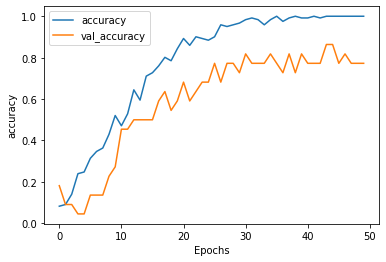

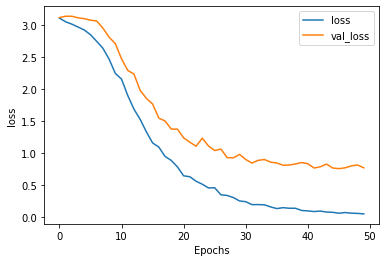

In [44]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [45]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [46]:
message = input("Enter message: ")
stemmed = stemSentence(message)
encoded = tokenizer.texts_to_sequences([stemmed])
padded = pad_sequences(encoded, maxlen=maxlen, padding="pre")
result = ohe.inverse_transform(model(padded))
le.inverse_transform(result)[0]

Enter message: What is your name


'NameQuery'